In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [29]:
filepath = '/Users/thomas/Desktop/thermistor-voltage/thermistor_data.csv'
filepath = '/Users/thomas/Desktop/thermistor-voltage/newdata.csv'
df = pd.read_csv(filepath)
df

,R_adc0,R_adc1,V_adc0,V_adc1
0,inf,inf,2960,2963
1,2000.00,inf,2949,2963
2,1000.00,inf,2940,2963
3,620.00,inf,2930,2963
4,310.00,inf,2905,2963
5,110.00,inf,2822,2963
6,55.00,inf,2692,2963
7,20.00,inf,2317,2963
8,10.00,inf,1915,2963
9,9.10,inf,1850,2963


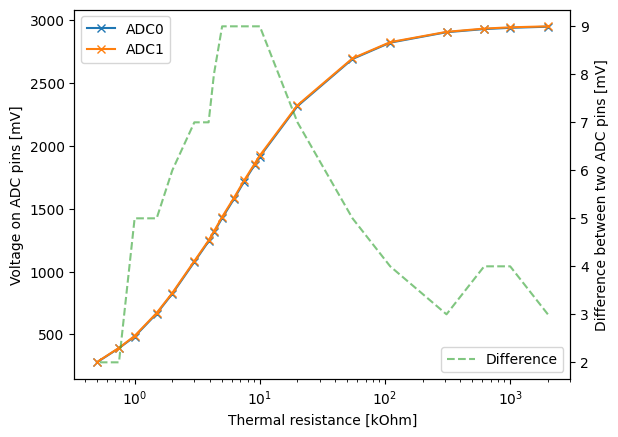

In [30]:
df_0 = df[df.R_adc1==np.inf]
df_0 = df_0[df_0.R_adc0!=np.inf][['R_adc0','V_adc0']]
r = list(df_0.R_adc0)
l1 = list(df_0.V_adc0)

df_1 = df[df.R_adc0==np.inf]
df_1 = df_1[df_1.R_adc1!=np.inf][['R_adc1','V_adc1']]
l2 = list(df_1.V_adc1)

diff = [np.abs(float(x)-float(y)) for x,y in zip(l1,l2)]

fig, ax = plt.subplots(1,1)
ax.plot(df.R_adc0, df.V_adc0, '-x', label='ADC0')
ax.plot(df.R_adc1, df.V_adc1, '-x', label='ADC1')
ax.legend()
ax2 = ax.twinx()
ax2.plot(r, diff, color='tab:green', alpha=0.6, linestyle='dashed', label='Difference')
ax2.legend(loc='lower right')
ax.set_ylabel('Voltage on ADC pins [mV]')
ax2.set_ylabel('Difference between two ADC pins [mV]')
ax.set_xlabel('Thermal resistance [kOhm]')
plt.xscale('log')
plt.show()

In [31]:
df_0 = df_0[df_0.R_adc0 <= 20]
df_0 = df_0[df_0.R_adc0 > 0.5].reset_index(drop=True)
df_1 = df_1[df_1.R_adc1 <= 20]
df_1 = df_1[df_1.R_adc1 > 0.5].reset_index(drop=True)
df_0

,R_adc0,V_adc0
0,20.00,2317
1,10.00,1915
2,9.10,1850
3,7.50,1717
4,6.20,1576
5,5.00,1426
6,4.30,1312
7,3.90,1241
8,3.00,1077
9,2.00,824


In [32]:
from ipywidgets import interact, FloatSlider

def R_T(V, R_ref=5.6, R_pic=49):
    V = V/1000
    return round(1/((3.3/V-1)/R_ref - 1/R_pic),2)

def plot_interactive(R_pico):
    df = df_0.copy()
    df.loc[:, 'R(V_adc0)'] = df['V_adc0'].apply(lambda V: R_T(V, R_pic=R_pico))
    df = df[['V_adc0', 'R_adc0', 'R(V_adc0)']]
    plt.xlim([0,21])
    plt.ylim([0,21])
    plt.xlabel('Thermistor impedance [kOhm]')
    plt.ylabel('Predicted Thermistor impedance [kOhm]')
    #plt.xlim([min(df.R_adc0)-200, max(df.R_adc0)+200])
    plt.plot(df.R_adc0, df.R_adc0, label='True')
    plt.plot(df.R_adc0, df['R(V_adc0)'], '-x', label='Predicted')
    plt.title(f'Predicting thermistor impedance')
    #plt.xscale('log')
    plt.legend(loc = 'upper left')
    plt.grid(axis='x')
    plt.show()

# Define the sliders
R_Pico_slider = FloatSlider(min=5, max=70, step=0.01, value=50, description='R_pico')

# Create the plot
interact(plot_interactive, R_pico=R_Pico_slider);

interactive(children=(FloatSlider(value=50.0, description='R_pico', max=70.0, min=5.0, step=0.01), Output()), …

In [33]:
filepath = '/Users/thomas/Downloads/datasheet.csv'
df_ss = pd.read_csv(filepath, decimal=',')
df_ss['T1'] = 1/(df_ss.temp + 273)
df_ss['log'] = np.log(df_ss.impedance)
df_ss['log3'] = np.log(df_ss.impedance)**3

# Predict 1/T with a linear regression
mod = smf.ols(formula='T1 ~ log + log3', data=df_ss)
np.random.seed(2) 
res = mod.fit()

# S-S equation
def temp(R_T):
    A, B, C = res.params.Intercept, res.params.log, res.params.log3
    return round(1 / (A + B*np.log(R_T) + C*np.log(R_T)**3) - 273,2)

def fahrenheit(celcius):
    return celcius*9/5 + 32

In [34]:
df_0['T_adc0'] = df_0['R_adc0'].apply(temp).apply(fahrenheit)
df_1['T_adc1'] = df_1['R_adc1'].apply(temp).apply(fahrenheit)
df_1

,R_adc1,V_adc1,T_adc1
0,20.00,2324,49.874
1,10.00,1924,77.000
2,9.10,1859,80.888
3,7.50,1726,89.024
4,6.20,1585,97.250
5,5.00,1435,106.826
6,4.30,1320,113.738
7,3.90,1248,118.274
8,3.00,1084,130.856
9,2.00,830,151.358


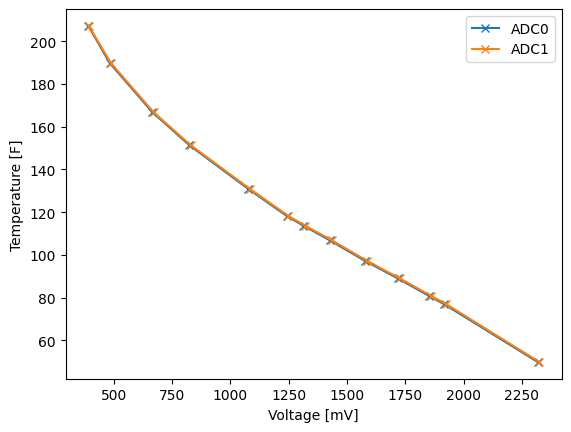

In [35]:
plt.plot(df_0.V_adc0, df_0.T_adc0, '-x', label='ADC0')
plt.plot(df_1.V_adc1, df_1.T_adc1, '-x', label='ADC1')
plt.xlabel('Voltage [mV]')
plt.ylabel('Temperature [F]')
plt.legend()
plt.show()

In [36]:
from ipywidgets import interact, FloatSlider

def R_T(V, R_ref=5.6, R_pic=49, R_pic2=100):
    V = V/1000
    if V <0.400:
        return round(1/((3.3/V-1)/R_ref - 1/(R_pic+10000)),2)
    elif V <1.400:
        return round(1/((3.3/V-1)/R_ref - 1/R_pic),2)
    elif V<1.600:
        return round(1/((3.3/V-1)/R_ref - 1/R_pic2),2)
    elif V<2.000:
        return round(1/((3.3/V-1)/R_ref - 1/(R_pic2+5)),2)
    else:
        return round(1/((3.3/V-1)/R_ref - 1/(R_pic2+11)),2)

def plot_interactive(R_pico, R_pico2):
    df = df_0.copy()
    df.loc[:, 'R(V_adc0)'] = df['V_adc0'].apply(lambda V: R_T(V, R_pic=R_pico, R_pic2=R_pico2))
    fig, ax = plt.subplots(1,1)
    ax.set_ylim([fahrenheit(0),fahrenheit(110)])
    ax.set_xlabel('Voltage [mV]')
    ax.set_ylabel('Temperature [F]')
    #plt.xlim([min(df.R_adc0)-200, max(df.R_adc0)+200])
    ax.plot(df.V_adc0, df.T_adc0, label='True')
    ax.plot(df.V_adc0, df['R(V_adc0)'].apply(temp).apply(fahrenheit), '-x', label='Predicted')
    ax2 = ax.twinx()
    true = list(df.T_adc0)
    pred = list(df['R(V_adc0)'].apply(temp).apply(fahrenheit))
    diffs = [np.abs(x-y) for x,y in zip(true,pred)]
    ax2.plot(list(df.V_adc0), diffs, color='green', alpha=0.5, linestyle='dashed')
    ax2.set_ylim([0,2])
    ax2.set_ylabel('Error [F]')
    plt.title(f'Predicting temperature')
    ax.legend(loc = 'upper right')
    plt.grid(axis='x')
    plt.show()

# Define the sliders
R_Pico_slider = FloatSlider(min=20, max=70, step=0.01, value=26.33, description='R_pico1')
R_Pico_slider2 = FloatSlider(min=20, max=70, step=0.01, value=28.23, description='R_pico2')

# Create the plot
interact(plot_interactive, R_pico=R_Pico_slider, R_pico2=R_Pico_slider2);

interactive(children=(FloatSlider(value=26.33, description='R_pico1', max=70.0, min=20.0, step=0.01), FloatSli…